# Contradictory, My Dear Watson
Your goal is to predict whether a given hypothesis is related to its premise by contradiction, entailment, or whether neither of those is true (neutral).
For each sample in the test set, you must predict a `0`, `1`, or `2` value for the variable.

Those values map to the logical condition as:
- 0 == entailment
- 1 == neutral
- 2 == contradiction

In [1]:
import pandas as pd
import numpy as np
import torch
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, TFBertModel


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
current_directory = os.getcwd()

# Path to your Excel file
train_file_path = current_directory+'/train.csv'
train = pd.read_csv(train_file_path)
train.head()

test_file_path = current_directory+'/test.csv'
test = pd.read_csv(test_file_path)
test.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


## Data Exploration

In [3]:
train.shape

(12120, 6)

In [4]:
test.shape

(5195, 5)

### Languages

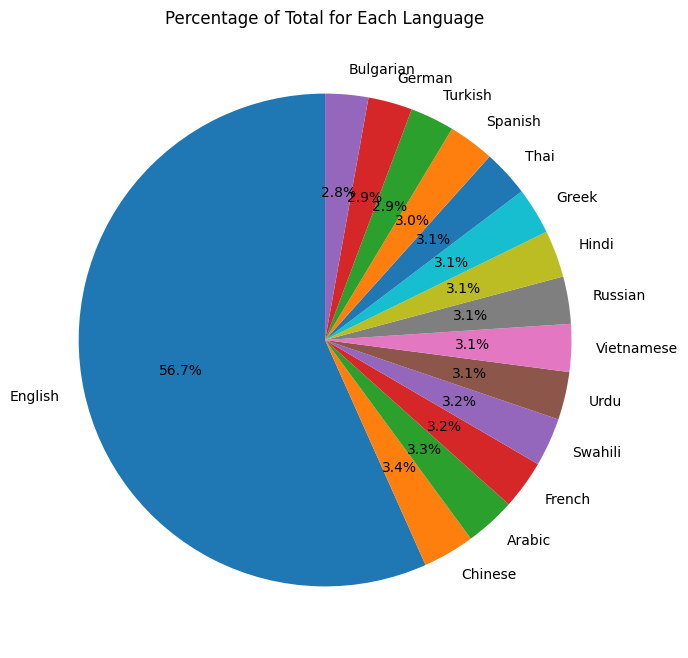

In [6]:
import matplotlib.pyplot as plt

# Calculate the percentage of total
value_counts = train['language'].value_counts()
percentage_of_total = (value_counts / value_counts.sum()) * 100

# Create a new DataFrame
result_df = pd.DataFrame({'Language': value_counts.index, 'Count': value_counts.values, 'Percentage': percentage_of_total.values})
result_df

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(result_df['Percentage'], labels=result_df['Language'], autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Total for Each Language')
plt.show()

## Translate other languages to English

In [34]:
from googletrans import Translator
from tqdm import tqdm
tqdm.pandas()

def translate2english(text):
    translator = Translator()
    # Retry translation in case of failure
    try:
        return translator.translate(text, dest="en").text
    except Exception as e:
        print(f"Translation failed for text: {text}")
        print(f"Error: {e}")
        return text  # Return the original text on failure


In [35]:
def translate_dataframe(df, premise_column='premise', hypothesis_column='hypothesis', language_column='lang_abv'):
    # Copy the original DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Apply translation only if the language is not English
    mask = df_copy[language_column] != 'en'
    df_copy.loc[mask, premise_column] = df_copy.loc[mask, 'premise'].progress_apply(lambda x: translate2english(x))
    df_copy.loc[mask, hypothesis_column] = df_copy.loc[mask, 'hypothesis'].progress_apply(lambda x: translate2english(x))

    return df_copy


In [37]:
train_translated = translate_dataframe(train, premise_column='premise', hypothesis_column='hypothesis', language_column='lang_abv')

  0%|          | 0/5250 [00:00<?, ?it/s]

  0%|          | 2/5250 [00:00<11:38,  7.51it/s]

Translation failed for text: Des petites choses comme celles-là font une différence énorme dans ce que j'essaye de faire.
Error: 'NoneType' object has no attribute 'group'


  0%|          | 3/5250 [00:00<19:19,  4.52it/s]

Translation failed for text: ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสดงออกและได้เล่นหลายบทบาทไปพร้อมกัน ๆ อาจช่วยให้เด็กจับความคล้ายคลึงและความแตกต่างระหว่างผู้คนในด้านความปรารถนา ความเชื่อ และความรู้สึกได้
Error: 'NoneType' object has no attribute 'group'


  0%|          | 4/5250 [00:00<19:56,  4.38it/s]

Translation failed for text: Bir çiftlikte birisinin, ağıla kapatılmış bu öküzleri kesmeliyiz dediğini duyabilirsiniz bu muhtemelen şu anlama gelir, yüklenecek olanları ayırın.
Error: 'NoneType' object has no attribute 'group'


  0%|          | 5/5250 [00:01<22:20,  3.91it/s]

Translation failed for text: ریاست ہائے متحدہ امریکہ واپس آنے پر، ہج ایف بی آئی کے ایجنٹوں کے ذریعے ہوائی اڈے پر ملاقات کی، تحقیقات کی، اور اگلے دن وفاقی گرین جوری سے پہلے اسامہ بن لادن کی تحقیقات سے ملاقات کی.
Error: 'NoneType' object has no attribute 'group'


  0%|          | 6/5250 [00:01<21:56,  3.98it/s]

Translation failed for text: Через каждые сто градусов пятна краски меняют свой цвет, она может быть красной и изменить цвет на синий.
Error: 'NoneType' object has no attribute 'group'


  0%|          | 7/5250 [00:01<23:10,  3.77it/s]

Translation failed for text: Може да не сме имали всичко, което сме искали или сме видели, че други хора имат, но тя осигуряваше необходимите неща, от които се нуждаехме.
Error: 'NoneType' object has no attribute 'group'


  0%|          | 8/5250 [00:01<23:45,  3.68it/s]

Translation failed for text: Es fallen zwanzig Prozent Zinsen an
Error: 'NoneType' object has no attribute 'group'


  0%|          | 9/5250 [00:02<23:10,  3.77it/s]

Translation failed for text: إذا أمكن ، تعرّف على المؤامرة مسبقًا.
Error: 'NoneType' object has no attribute 'group'


  0%|          | 10/5250 [00:02<23:44,  3.68it/s]

Translation failed for text: 我希望你的领主能够最终开始认识到，向这样的人授予国王委员会的愚蠢行为反对我的所有建议。
Error: 'NoneType' object has no attribute 'group'


  0%|          | 11/5250 [00:02<22:42,  3.85it/s]

Translation failed for text: म्जोडी का दावा है कि वह शादी करने के लिए मोरक्को के घर चला गया लेकिन वहाँ एक कार दुर्घटना में घायल होनेके कारण कर नहीं पाया ।
Error: 'NoneType' object has no attribute 'group'


  0%|          | 12/5250 [00:03<23:12,  3.76it/s]

Translation failed for text: Watoto wangegonga milango ya majirani zao na
Error: 'NoneType' object has no attribute 'group'


  0%|          | 13/5250 [00:03<23:05,  3.78it/s]

Translation failed for text: Уверяю вас, сэр, что я был полностью осведомлен обо всем.
Error: 'NoneType' object has no attribute 'group'


  0%|          | 14/5250 [00:03<22:45,  3.83it/s]

Translation failed for text: Lạnh hơn và xa hơn bao giờ hết đã phát triển tiếng nói của lãnh chúa.
Error: 'NoneType' object has no attribute 'group'


  0%|          | 15/5250 [00:03<23:03,  3.78it/s]

Translation failed for text: 27 La dificultad aumenta a medida que la necesidad de modificaciones de la caldera que se han de tomar para adaptar el SCR a la instalación también aumenta.
Error: 'NoneType' object has no attribute 'group'


  0%|          | 16/5250 [00:04<22:46,  3.83it/s]

Translation failed for text: Κατά συνέπεια, οι κυβερνητικοί υπεύθυνοι λήψης αποφάσεων και προϊστάμενοι υιοθετούν νέους τρόπους σκέψης, εξετάζοντας διαφορετικούς τρόπους επίτευξης των στόχων και χρησιμοποιώντας νέες πληροφορίες για την καθοδήγηση των αποφάσεων.
Error: 'NoneType' object has no attribute 'group'


  0%|          | 17/5250 [00:04<23:54,  3.65it/s]

Translation failed for text: Mashua kama hayo yalitengenezwa kuruhusu fursa ya kufiki kwa meli zinazowasili.
Error: 'NoneType' object has no attribute 'group'


  0%|          | 18/5250 [00:04<24:01,  3.63it/s]

Translation failed for text: Sijawahi kuelewa kwanini uandishi wa kimataifa wa simu ya kitaifa haitumiwi katika kamusi ya kiingereza ya kila aina, lakini hii ni zaidi ya upeo wa maneno yetu katika ukaguzi huu.
Error: 'NoneType' object has no attribute 'group'


  0%|          | 19/5250 [00:04<23:52,  3.65it/s]

Translation failed for text: 争端，管理现在都指向做的这些食物券，当然也可以转向基本福利 —— TANF。
Error: 'NoneType' object has no attribute 'group'


  0%|          | 20/5250 [00:05<22:50,  3.82it/s]

Translation failed for text: Die Sozialversicherung enthält keine etablierten Programme ausschließlich oder vor allem für Bundesangestellte, solche wie: Rente und andere Altersvorsorgen.
Error: 'NoneType' object has no attribute 'group'


KeyboardInterrupt: 

## Tokenizer
We use the BERT (Bidirectional Encoder Representations from Transformers) model from huggingface.

https://huggingface.co/docs/transformers/model_doc/bert


Per the authors:
<i>It’s a bidirectional transformer pretrained using a combination of masked language modeling objective and next sentence prediction on a large corpus comprising the Toronto Book Corpus and Wikipedia</i>

It is a pre-trained deep learning model for in natural language processing (NLP) tasks, including sentence classification.

In [5]:
model_name = 'bert-base-multilingual-cased' # the BERT-base-multilingual-cased version, which is a BERT model that has been pre-trained on text in 104 languages
tokenizer = BertTokenizer.from_pretrained(model_name)

In [6]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

In [ ]:
# BERT uses three kind of input data- input word IDs, input masks, and input type IDs.

# These allow the model to know that the premise and hypothesis are distinct sentences, and also to ignore any padding from the tokenizer.

# We add a [CLS] token to denote the beginning of the inputs, and a [SEP] token to denote the separation between the premise and the hypothesis. We also need to pad all of the inputs to be the same size. For more information about BERT inputs, see: https://huggingface.co/transformers/model_doc/bert.html#tfbertmodel

In [7]:
def bert_encode(hypotheses, premises, tokenizer):
    
    # Convert NumPy arrays to lists
    hypotheses = hypotheses.tolist()
    premises = premises.tolist()
    
    # Encode hypotheses and premises using the tokenizer
    encodings = tokenizer(hypotheses, premises, padding=True, truncation=True, return_tensors='tf')

    # Extract input tensors from encodings
    input_word_ids = encodings['input_ids']
    input_mask = encodings['attention_mask']
    input_type_ids = encodings['token_type_ids']

    # Create dictionary of input tensors
    inputs = {
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    }

    return inputs

In [8]:
# Example usage
train_input = bert_encode(train.hypothesis.values, train.premise.values, tokenizer)

2024-01-05 14:13:25.376412: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
train_input

{'input_word_ids': <tf.Tensor: shape=(12120, 259), dtype=int32, numpy=
 array([[  101, 10117, 23123, ...,     0,     0,     0],
        [  101, 46184, 15647, ...,     0,     0,     0],
        [  101,   147,   112, ...,     0,     0,     0],
        ...,
        [  101, 10377, 25259, ...,     0,     0,     0],
        [  101, 10117, 13192, ...,     0,     0,     0],
        [  101, 68795, 15698, ...,     0,     0,     0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(12120, 259), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(12120, 259), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 

In [10]:
from tensorflow.keras.layers import Input, Dense, Lambda
import tensorflow as tf
from transformers import TFBertModel

max_len = 100

def build_model(max_len=max_len):
    # Load BERT model
    bert_encoder = TFBertModel.from_pretrained(model_name)

    # Define input layers
    input_word_ids = Input(shape=(259,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(259,), dtype=tf.int32, name="input_mask")
    input_type_ids = Input(shape=(259,), dtype=tf.int32, name="input_type_ids")

    # Use Lambda layer to select the first 100 elements (to preserve compute)
    truncated_input_word_ids = Lambda(lambda x: x[:, :max_len])(input_word_ids)
    truncated_input_mask = Lambda(lambda x: x[:, :max_len])(input_mask)
    truncated_input_type_ids = Lambda(lambda x: x[:, :max_len])(input_type_ids)

    # Build model architecture
    embedding = bert_encoder([truncated_input_word_ids, truncated_input_mask, truncated_input_type_ids])[0]
    #embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = Dense(3, activation='softmax')(embedding[:, 0, :])

    # Create the model
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)

    # Add the pooler layer's weights to regularization losses
    pooler_layer = bert_encoder.bert.pooler
    pooler_weights = pooler_layer.trainable_weights
    for w in pooler_weights:
        model.add_loss(lambda w=w: tf.keras.regularizers.l2(1e-4)(w))

    # Compile the model
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Set up distributed training strategy for TPUs
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()  # for CPU and single GPU

# Build and summarize the model within the strategy scope
with strategy.scope():
    model = build_model()
    model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 259)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 259)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 259)]        0           []                               
                                                                                                  
 lambda (Lambda)                (None, 100)          0           ['input_word_ids[0][0]']         
                                                                                              

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
print(train_input['input_word_ids'].shape)
print(train_input['input_mask'].shape)
print(train_input['input_type_ids'].shape)

(12120, 259)
(12120, 259)
(12120, 259)


In [12]:
model.fit(train_input, train.label.values, epochs=2, verbose=1, batch_size=64, validation_split=0.2)

Epoch 1/2
152/152 [==============================] - 13159s 86s/step - loss: 1.0263 - accuracy: 0.4886 - val_loss: 0.8745 - val_accuracy: 0.6114
Epoch 2/2
152/152 [==============================] - 14261s 94s/step - loss: 0.8022 - accuracy: 0.6531 - val_loss: 0.8164 - val_accuracy: 0.6394


In [14]:
# save model just in-case
model.save("contradictory_my_dear_watson_model", save_format='tf', include_optimizer=False, save_traces=False)


INFO:tensorflow:Assets written to: contradictory_my_dear_watson_model/assets


INFO:tensorflow:Assets written to: contradictory_my_dear_watson_model/assets


In [15]:
# saving using the HDF5 format instead of the TensorFlow SavedModel format. 
# HDF5 is a more flexible format and may handle non-trainable variables better. 
model.save("contradictory_my_dear_watson_model.h5", save_format='h5')


In [ ]:
# loading models back in

# For TensorFlow SavedModel format
loaded_model = tf.keras.models.load_model("contradictory_my_dear_watson_model")

# For HDF5 format
loaded_model = tf.keras.models.load_model("contradictory_my_dear_watson_model.h5")


## Generating Submissions

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming max_len is the desired sequence length
max_len = 259

# Encode test data
test_input = bert_encode(test.premise.values, test.hypothesis.values, tokenizer)

# Pad sequences (to make them the same input shape as our training data)
padded_test_input = {
    'input_word_ids': pad_sequences(test_input['input_word_ids'], maxlen=max_len, padding='post'),
    'input_mask': pad_sequences(test_input['input_mask'], maxlen=max_len, padding='post'),
    'input_type_ids': pad_sequences(test_input['input_type_ids'], maxlen=max_len, padding='post'),
}

# Generate predictions
predictions = [np.argmax(i) for i in model.predict(padded_test_input)]


In [21]:
submission = test.id.copy().to_frame()
submission['prediction'] = predictions
submission

,id,prediction
0,c6d58c3f69,1
1,cefcc82292,2
2,e98005252c,1
3,58518c10ba,1
4,c32b0d16df,0
...,...,...
5190,5f90dd59b0,2
5191,f357a04e86,1
5192,1f0ea92118,0
5193,0407b48afb,0


In [22]:
submission.to_csv("submission.csv", index = False)